# 3. 전처리 미션(2): 태양광 발전량 예측

주어진 발전소/시간별 기상, 태양 그리고 발전량 데이터를 통해 태양광 발전량 데이터를 예측하는 분석 모델을 생성해봅니다.

👀 **데이터 컬럼 소개**


| **컬럼명**        | **설명**                                                                                           |
|-------------------|----------------------------------------------------------------------------------------------------|
| **ID**            | 발전소 고유 식별자                                                                                       |
| **DATE**          | 날짜 (YYYYMMDD)                                                                                              |
| **HOUR**          | 시간 (24시간 형식)                                                                                 |
| **CAPACITY**          | 발전소 용량(최대 발전량)                                                                                |
| **GHI**           | 수평면 일사량 (Global Horizontal Irradiance)                                                       |
| **DNI**           | 수직면 일사량 (Direct Normal Irradiance)                                                          |
| **DHI**           | 확산 일사량 (Diffuse Horizontal Irradiance)                                                       |
| **TEMP**      | 체감 온도                                                                                         |
| **CLOUDS**        | 구름의 양 (%로 표현)                                                                              |
| **DEWPT**         | 이슬점 온도                                                                                       |
| **PRES**          | 기압                                                                                               |
| **RH**            | 상대 습도                                                                                         |
| **SLP**           | 해면 기압 (Sea Level Pressure)                                                                    |
| **UV**            | 자외선 지수                                                                                        |
| **VIS**           | 가시 거리                                                                                         |
| **WIND_DIR**      | 풍향                                                                                               |
| **WIND_SPD**      | 풍속                                                                                               |
| **HUMIDITY**      | 습도                                                                                               |
| **RAIN**          | 강수량                                               |
| **SNOW**      | 적설량                                                                                 |
| **GEN**           | 발전량                                                                                 |


## 3.1 EDA(데이터 탐색)

### 3.1.1 데이터 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
solar = pd.read_csv("./data/solar_data.csv")
# 데이터 확인
solar.head()

,ID,DATE,HOUR,CAPACITY,GHI,DNI,DHI,TEMP,CLOUDS,DEWPT,...,RH,SLP,UV,VIS,WIND_DIR,WIND_SPD,HUMIDITY,RAIN,SNOW,GEN
0,A,20220826,0,674,0.0,0.0,0.0,20.7,100.0,18.6,...,91.0,1007.1,0.0,15.0,282.0,1.66,92.0,0.1,0.0,0.0
1,A,20220826,1,674,0.0,0.0,0.0,20.3,100.0,18.6,...,92.0,1007.0,0.0,16.0,288.0,1.69,87.0,0.0,0.0,0.0
2,A,20220826,2,674,0.0,0.0,0.0,20.4,100.0,18.6,...,93.0,1006.7,0.0,16.0,280.0,1.56,80.0,0.0,0.0,0.0
3,A,20220826,3,674,0.0,0.0,0.0,19.6,100.0,18.1,...,94.0,1006.9,0.0,16.0,273.0,1.74,72.0,0.0,0.0,0.0
4,A,20220826,4,674,0.0,0.0,0.0,18.7,100.0,16.2,...,86.0,1006.7,0.0,16.0,281.0,1.64,70.0,0.0,0.0,0.0


🔥 **꿀팁**

- Pandas 데이터프레임과 NumPy 배열에서 큰 숫자가 지수 표현식(e-notation)으로 표시되지 않도록 하려면, Pandas와 NumPy의 출력 옵션을 조정해야 함

In [2]:
# Pandas 설정: 지수 표현식 대신 부동소수점으로 출력
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# NumPy 설정: 지수 표현식 대신 부동소수점으로 출력
np.set_printoptions(formatter={'float_kind': '{:f}'.format})

### 3.1.2 데이터 개요 확인하기

💥 **MISSION**

> Dataframe의 info, describe 기능을 활용하여 주어진 데이터를 해석해보기

In [3]:
solar_info = solar.info()
solar_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91975 entries, 0 to 91974
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        91975 non-null  object 
 1   DATE      91975 non-null  int64  
 2   HOUR      91975 non-null  int64  
 3   CAPACITY  91975 non-null  int64  
 4   GHI       91975 non-null  float64
 5   DNI       91975 non-null  float64
 6   DHI       91975 non-null  float64
 7   TEMP      91975 non-null  float64
 8   CLOUDS    91975 non-null  float64
 9   DEWPT     91975 non-null  float64
 10  PRES      91975 non-null  float64
 11  RH        91975 non-null  float64
 12  SLP       91975 non-null  float64
 13  UV        91975 non-null  float64
 14  VIS       91975 non-null  float64
 15  WIND_DIR  91975 non-null  float64
 16  WIND_SPD  91975 non-null  float64
 17  HUMIDITY  91975 non-null  float64
 18  RAIN      91975 non-null  float64
 19  SNOW      91975 non-null  float64
 20  GEN       91975 non-null  fl

In [4]:
solar_desc = solar.describe()
solar_desc

,DATE,HOUR,CAPACITY,GHI,DNI,DHI,TEMP,CLOUDS,DEWPT,PRES,RH,SLP,UV,VIS,WIND_DIR,WIND_SPD,HUMIDITY,RAIN,SNOW,GEN
count,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000,91975.000
mean,20222591.493,11.502,1182.400,178.517,302.873,35.970,5.612,50.710,1.546,984.249,68.522,1020.470,0.963,14.826,192.072,2.317,69.167,0.120,0.739,129.371
std,3401.345,6.930,908.100,256.245,367.596,43.998,12.736,37.931,10.943,33.391,19.969,6.891,1.514,3.602,109.232,1.795,21.863,1.058,2.047,302.530
min,20220826.000,0.000,56.000,0.000,0.000,0.000,-32.600,0.000,-30.600,859.700,12.000,961.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,20221003.000,5.000,701.000,0.000,0.000,0.000,-4.000,5.000,-6.700,940.500,54.000,1016.000,0.000,16.000,82.000,1.100,53.000,0.000,0.000,0.000
50%,20221110.000,12.000,947.000,0.000,0.000,0.000,8.600,56.000,2.600,999.000,70.000,1021.000,0.000,16.000,228.000,1.802,71.000,0.000,0.000,0.000
75%,20221219.000,18.000,1028.000,358.730,728.290,83.540,15.500,83.000,9.600,1009.500,86.000,1026.000,1.506,16.000,279.000,3.000,88.000,0.000,0.000,115.920
max,20230126.000,23.000,4050.000,947.350,927.160,121.930,38.900,100.000,27.000,1030.900,100.000,1034.000,9.000,16.000,360.000,23.194,100.000,77.000,19.100,2894.400


📍**발전소별 요약정보**

In [5]:
# 발전소 개수
num_plants = solar['ID'].unique()
print("발전소 개수 : ", len(num_plants))

발전소 개수 :  25


In [6]:
# 발전소별 최대 용량 추출
max_capacity_per_plant = solar.groupby('ID')['CAPACITY'].max()

# 결과 출력
print("발전소별 용량:\n", max_capacity_per_plant)

발전소별 용량:
 ID
A     674
B    4050
C     701
D    2666
E     720
F    2742
G     994
H     500
I     543
J    2783
K     947
L     420
M     502
N      56
O     900
P     705
Q     974
R    1907
S     900
T     998
U    1028
V    1028
W     903
X     955
Y     964
Name: CAPACITY, dtype: int64


In [7]:
# 발전소별 데이터 건수 추출
data_count_per_plant = solar.groupby('ID').size()
print("\n발전소별 데이터 건수:\n", data_count_per_plant)


발전소별 데이터 건수:
 ID
A    3679
B    3679
C    3679
D    3679
E    3679
F    3679
G    3679
H    3679
I    3679
J    3679
K    3679
L    3679
M    3679
N    3679
O    3679
P    3679
Q    3679
R    3679
S    3679
T    3679
U    3679
V    3679
W    3679
X    3679
Y    3679
dtype: int64


🔬 **데이터 요약 결과 해석**

> 본 예제는 실제 기상청, 한국전력 등에서 데이터 제공 서비스를 통해 받은 데이터임으로 이상치는 존재하지 않습니다.

1. 발전소는 총 25개이며 각각의 최대 발전용량이 다름
2. 범주형 데이터는 발전소 번호 외 존재하지 않음
3. 수치형 데이터의 스케일이 다름
4. PRECIP(강수량) 변수에는 결측치 존재

✅ GEN이 수치형이기에 회귀(Regression) 분석을 수행함

### 3.1.3 시각화

**1. 수치형 변수 시각화**

💥 **MISSION**

> list에 수치형 변수들을 정의해보기

In [8]:
# 수치형
# 'ID', 'DATE', 'HOUR', 'CAPACITY'는 의미가 없는 수치형 데이터이므로 제외
continuous_columns = solar.columns.difference(['ID', 'DATE', 'HOUR', 'CAPACITY'])
continuous_columns

Index(['CLOUDS', 'DEWPT', 'DHI', 'DNI', 'GEN', 'GHI', 'HUMIDITY', 'PRES',
       'RAIN', 'RH', 'SLP', 'SNOW', 'TEMP', 'UV', 'VIS', 'WIND_DIR',
       'WIND_SPD'],
      dtype='object')

📍 **히스토그램**
- 수치형 변수들을 히스토그램으로 시각하여 이상치에 대한 판단

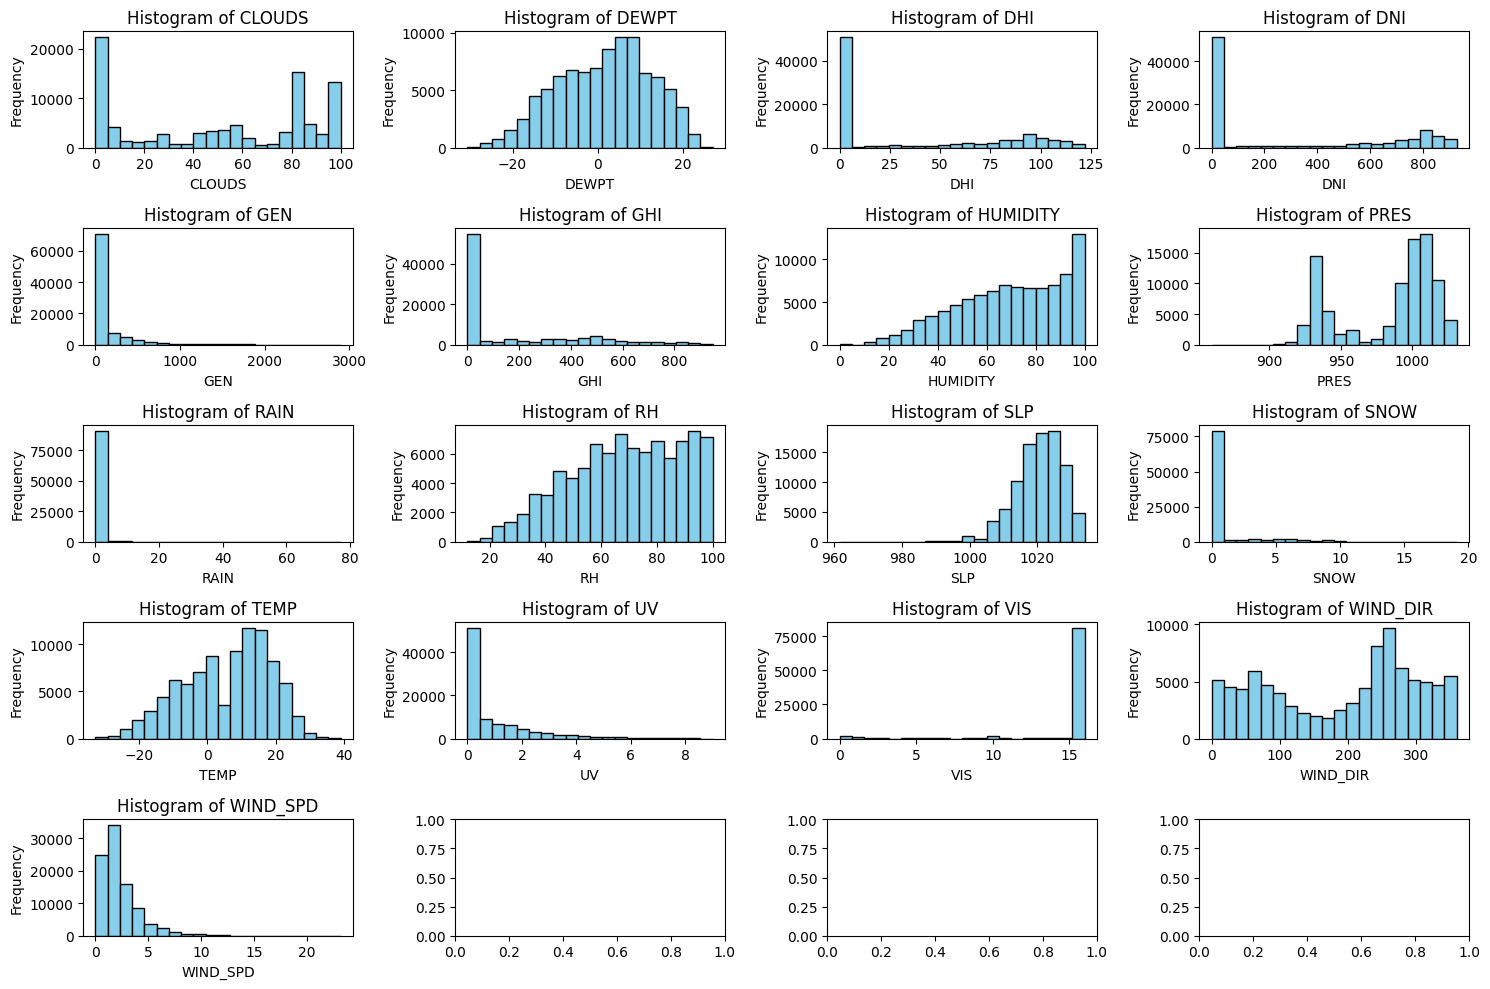

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 10))

for i, column in enumerate(continuous_columns):

    row = i // 4
    col = i % 4
    solar[column].plot(kind='hist', bins=20, ax=axes[row, col], color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'Histogram of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

🔬 **수치형 변수 시각화 결과 해석**

- 본 예제는 기상청, 한국전력 등으로 부터 제공받은 데이터를 사용함으로 이상치에 대한 검증은 하지 않음'

**2. 범주형 변수 시각화**

✅ 발전소가 25개이기에 발전소별 발전량을 통해 차이가 있는지 확인해보는 것도 좋을 것 같습니다.

💥 **MISSION**

> 발전소/시간별 발전량 평균에 대한 데이터프레임을 생성해보기

In [10]:
# 개별 발전소별 발전량 평균
plant_data = solar[solar['ID'] == 'A']
avg_generation_per_hour = plant_data.groupby('HOUR')['GEN'].mean().reset_index(drop=True)
pd.DataFrame(avg_generation_per_hour).rename(columns={'GEN': 'A'})

,A
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,0.000
6,0.698
7,22.963
8,90.538
9,196.338


In [11]:
# 발전소별 시간별 발전량 평균 계산

df_avg_gen = pd.DataFrame()
for plant in solar['ID'].unique():
    plant_data = solar[solar['ID'] == plant]
    avg_generation_per_hour = plant_data.groupby('HOUR')['GEN'].mean().reset_index(drop=True)
    tmp = pd.DataFrame(avg_generation_per_hour).rename(columns={'GEN': plant})
    df_avg_gen = pd.concat([df_avg_gen, tmp], axis=1)

df_avg_gen.T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
A,0.000,0.000,0.000,0.000,0.000,0.000,0.698,22.963,90.538,196.338,...,267.066,162.730,60.545,10.434,0.481,0.000,0.000,0.000,0.000,0.000
B,0.000,0.000,0.000,0.000,0.000,0.000,1.529,87.247,399.318,904.729,...,1572.306,1075.082,470.400,109.694,9.671,0.000,0.000,0.000,0.000,0.000
C,0.000,0.000,0.000,0.000,0.000,0.000,0.522,12.588,63.732,151.807,...,256.438,145.271,69.294,17.920,1.158,0.000,0.000,0.000,0.000,0.000
D,0.000,0.000,0.000,0.000,0.000,0.000,4.471,78.635,354.808,709.757,...,791.592,530.086,219.953,49.208,4.816,0.000,0.000,0.000,0.000,0.000
E,0.000,0.000,0.000,0.000,0.000,0.000,1.379,22.772,91.746,190.042,...,230.725,147.812,63.896,14.842,1.482,0.000,0.000,0.000,0.000,0.000
F,0.000,0.000,0.000,0.000,0.000,0.000,5.192,96.988,393.663,756.722,...,865.318,566.306,236.267,53.788,5.490,0.000,0.000,0.000,0.000,0.000
G,0.000,0.000,0.000,0.000,0.000,0.000,1.449,25.849,118.259,263.482,...,399.294,284.273,133.304,24.673,1.647,0.000,0.000,0.000,0.000,0.000
H,0.000,0.000,0.000,0.000,0.000,0.000,0.256,13.339,59.572,119.649,...,162.798,117.287,57.774,10.805,0.576,0.000,0.000,0.000,0.000,0.000
I,0.000,0.000,0.000,0.000,0.000,0.000,1.635,26.516,91.853,172.185,...,196.769,131.404,49.220,9.550,0.709,0.000,0.000,0.000,0.000,0.000
J,0.000,0.000,0.000,0.000,0.000,0.000,1.114,53.443,272.643,650.180,...,1220.424,940.031,563.906,115.404,3.796,0.000,0.000,0.000,0.000,0.000


📍 **시간대별 발전량 그래프(분할)**

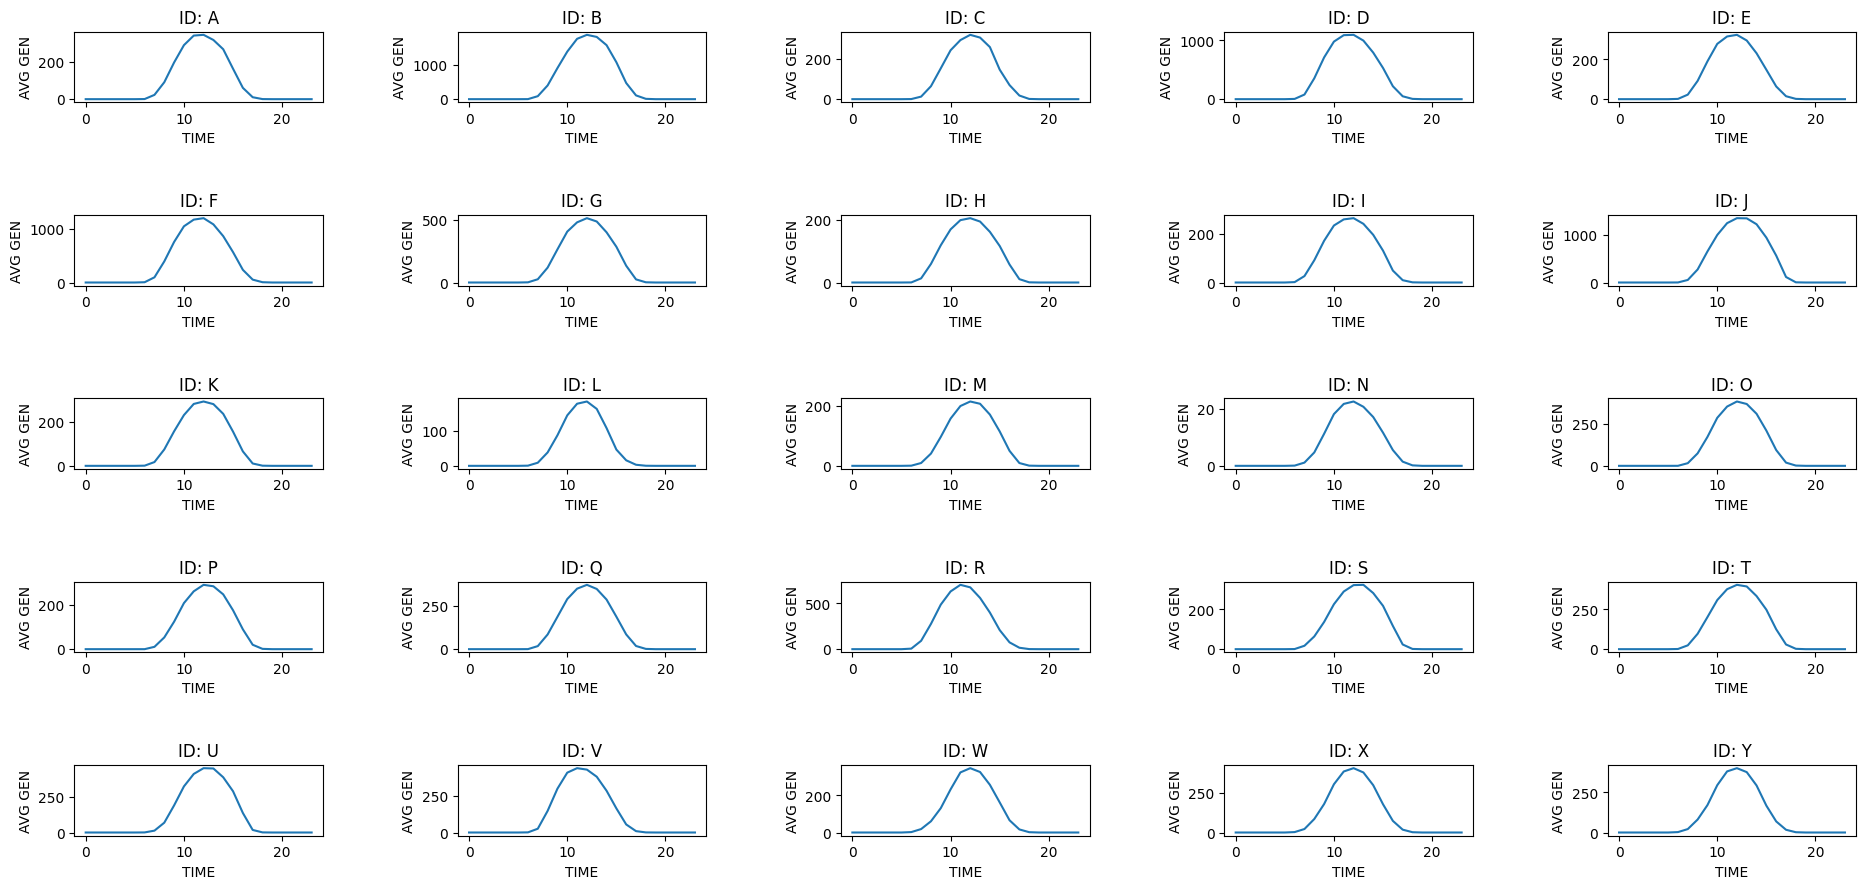

In [12]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 10))
fig.tight_layout(pad=6.0)

for (id_, data), ax in zip(df_avg_gen.T.iterrows(), axes.flatten()):
    data.plot(ax=ax, kind='line')
    ax.set_title(f'ID: {id_}')
    ax.set_xlabel('TIME')
    ax.set_ylabel('AVG GEN')

for i in range(len(df_avg_gen.T), 25):
    fig.delaxes(axes.flatten()[i])

plt.show()

📍 **시간대별 발전량 그래프(전체)**

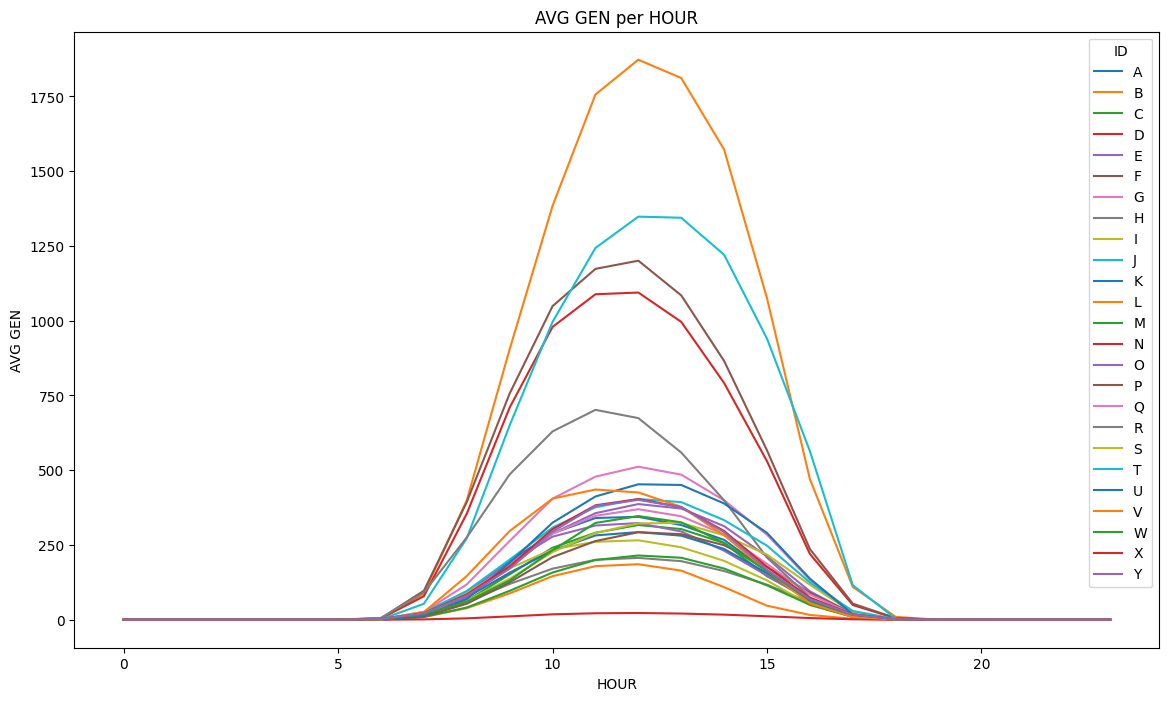

In [13]:
import matplotlib.pyplot as plt

# 그래프 그리기
df_avg_gen.plot(kind='line', figsize=(14, 8))
plt.title('AVG GEN per HOUR')
plt.xlabel('HOUR')
plt.ylabel('AVG GEN')
plt.legend(title='ID')
plt.show()

🔬 **범주형 변수 시각화 결과 해석**

- 발전소/시간별 평균 발전량은 최대 발전 용량인 CAPACITY에 따라 달라짐
- 발전량의 동향은 일사량이 가장 많은 11~13시 사이에 가장 많고 시간에 따라 증가했다 감소함

## 3.2 데이터 전처리

### 3.2.1 Feature Engineering

👀 **Definition**
> 데이터 분석에서 모델의 성능을 높이기 위해 원시 데이터를 변형하고 새로운 변수를 생성하는 과정

- 알고있는 지식, 도메인 지식 등을 활용
- 보유한 데이터에서 새로운 데이터를 만들어 설명력을 높임


📍 **시간 변환**

시간 데이터는 모델이 해석하기 적합하지 않습니다. 현재 다루고 있는 데이터가 시간별 날씨 데이터이기에 명확한 주기성을 가지고 있기 때문입니다. 또한 발전량은 정규분포와 같이 증가하다 감소하지만 시간은 0-24로 증가하다가 다시 0이되는 직선의 형태를 나타냅니다. 따라서 이러한 주기성을 담을 수 있도록 처리해주어야 합니다.

💥 **MISSION**

> 날짜와 시간을 합쳐 YYYY-MM-DD HH:MM:SS 형태로 변환

In [14]:
solar['DATE_TIME'] = pd.to_datetime(solar['DATE'].astype(str) + ' ' + solar['HOUR'].astype(str) + ':00:00')
solar.drop(columns=['DATE', 'HOUR'], inplace=True)

Text(0.5, 1.0, 'Time of day signal')

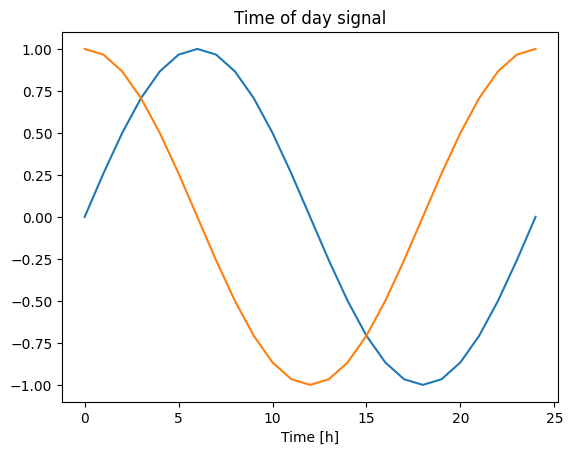

In [15]:
# 날짜와 시간이 주기성을 갖도록 변환함
date_time = solar['DATE_TIME']
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

solar['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
solar['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
solar['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
solar['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(solar['Day sin'])[:25])
plt.plot(np.array(solar['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

📍 **풍향, 풍속 변환**

WIND_DIR는 풍향을 각도로 나타냅니다. 각도는 0부터 360까지 이루어져 있지만, 이는 모델이 학습하기 쉬운 표현이 아닙니다. 현실에서 0도와 360도는 서로 가깝게 보여야 하기 때문입니다. 현재 풍향 및 풍속에 대한 분포는 아래와 같이 나타납니다.

Text(0, 0.5, 'Wind Velocity [m/s]')

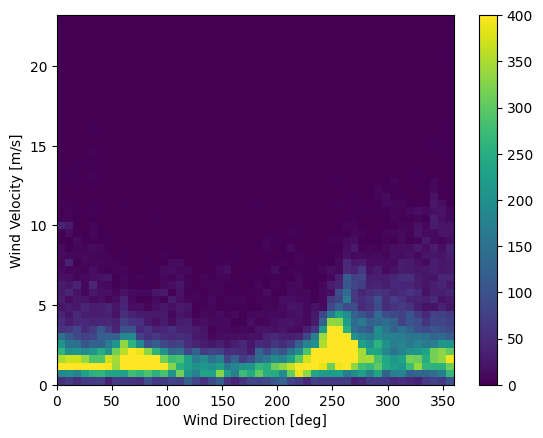

In [16]:
plt.hist2d(solar['WIND_DIR'], solar['WIND_SPD'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

분포를 보았을 때, 노란색이 0부터 360까지 펼쳐저 있음을 확인할 수 있다. 이를 앞서 이야기하였던 이해해가 쉬운 변수로 변환하기 위해 풍향, 풍속을 합쳐 바람 벡터로 만들어본다.

(-13.63297358462116, 20.6, -16.104897439381983, 18.764178364133656)

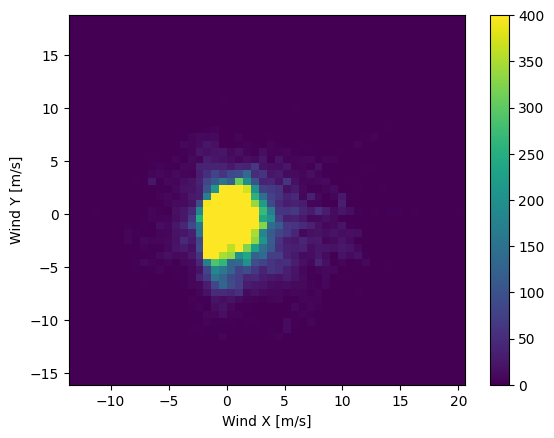

In [17]:
wv = solar['WIND_SPD']
max_wv = solar['WIND_SPD'].max()

wd_rad = solar['WIND_DIR']*np.pi / 180

solar['Wx'] = wv*np.cos(wd_rad)
solar['Wy'] = wv*np.sin(wd_rad)

solar.drop(columns=['WIND_DIR', 'WIND_SPD'], inplace=True)
# solar['max Wx'] = max_wv*np.cos(wd_rad)
# solar['max Wy'] = max_wv*np.sin(wd_rad)

plt.hist2d(solar['Wx'], solar['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

변환된 분포는 이전보다 모델이 이해하기 쉬워 보입니다.

📍 **비, 눈 변환**

비는 겨울에 잘 내리지 않고, 눈은 여름에 내리지 않습니다. 때문에 계절에 따라 대부분의 데이터가 0으로 분포되어 있습니다. 아래 그래프를 통해 확인하면 그 차이를 더 확실히 알 수 있습니다.

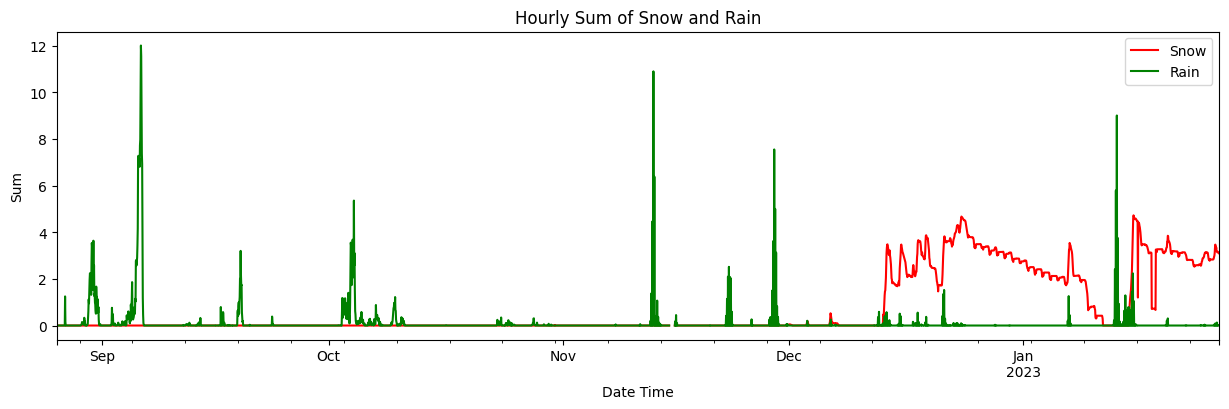

In [18]:
# 'DATE_TIME'을 인덱스로 설정
solar.set_index('DATE_TIME', inplace=True)

# 날짜별, 시간별로 SNOW와 RAIN의 합계 계산
df_sum = solar.resample('H').mean()
solar.reset_index(inplace=True)

# 시계열 그래프 생성
plt.figure(figsize=(15, 4))
df_sum['SNOW'].plot(label='Snow', color='red')
df_sum['RAIN'].plot(label='Rain', color='green')
plt.title('Hourly Sum of Snow and Rain')
plt.xlabel('Date Time')
plt.ylabel('Sum')
plt.legend()
plt.show()

유의미한 변수이나 대부분이 0인 경우 모델의 해석력이 떨어질 수 있으므로, 두 변수를 하나로 합쳐 새로운 변수로 만들어 보는 것도 좋은 방법입니다.

💥 **MISSION**

> RAIN과 SNOW를 합쳐 하나의 변수 RAIN_SNOW로 만들어보기

In [19]:
solar['RAIN_SNOW'] = solar['RAIN'] + solar['SNOW']
solar.drop(columns=['RAIN', 'SNOW'], inplace=True)

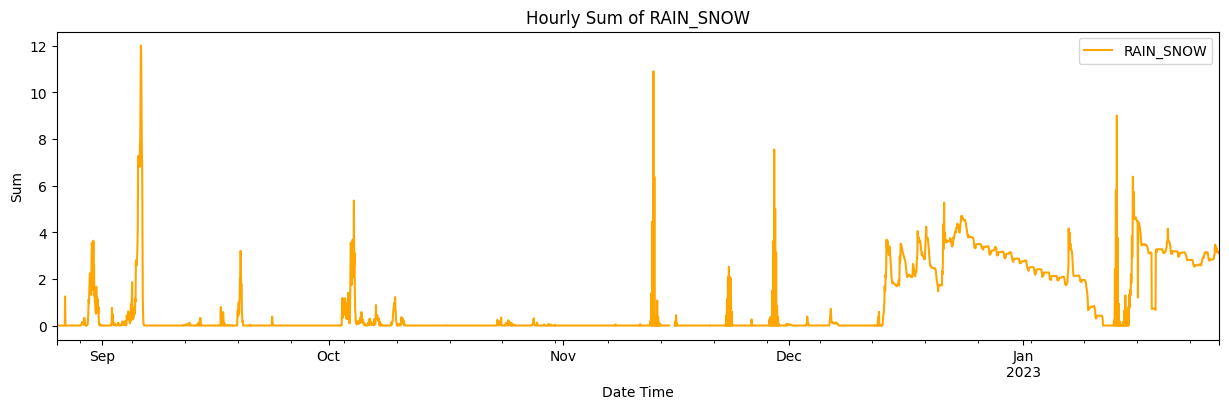

In [20]:
# 'DATE_TIME'을 인덱스로 설정
solar.set_index('DATE_TIME', inplace=True)

# 날짜별, 시간별로 SNOW와 RAIN의 합계 계산
df_sum = solar.resample('H').mean()
solar.reset_index(inplace=True)

# 시계열 그래프 생성
plt.figure(figsize=(15, 4))
df_sum['RAIN_SNOW'].plot(label='RAIN_SNOW', color='orange')
plt.title('Hourly Sum of RAIN_SNOW')
plt.xlabel('Date Time')
plt.ylabel('Sum')
plt.legend()
plt.show()

🔬 **Feature engineering 결과 해석**

- 태양광 발전을 위해 도메인 지식을 활용하여 새로운 변수들을 생성함

### 3.2.2 시계열 데이터 분할

일반적인 데이터들에 대해서는 랜덤하게 train/validation/test를 구성하지만, 시계열 데이터는 랜덤을 제외하고 시간을 기준으로 분할을 수행합니다.

💥 **MISSION**

> 전체 데이터의 날짜 중 70%, 90%가 되는 날을 찾아서 train, validation, test로 구분해보기

In [21]:
# 전체 데이터 날짜
date_array = solar['DATE_TIME'].unique()

# 전체 데이터 길이 계산
total_dates = len(date_array)

# 70%와 90% 위치 계산
index_70 = int(total_dates * 0.7)
index_90 = int(total_dates * 0.9)

# 해당 위치의 날짜 추출
date_70 = date_array[index_70]
date_90 = date_array[index_90]

print(f"70%에 해당하는 날짜: {date_70}")
print(f"90%에 해당하는 날짜: {date_90}")

70%에 해당하는 날짜: 2022-12-12T00:00:00.000000000
90%에 해당하는 날짜: 2023-01-11T16:00:00.000000000


In [22]:
# 데이터 셋 분할
train_data = solar[solar['DATE_TIME'] < date_70].reset_index(drop=True)
validation_data = solar[(solar['DATE_TIME'] >= date_70) & (solar['DATE_TIME'] < date_90)].reset_index(drop=True)
test_data = solar[solar['DATE_TIME'] >= date_90].reset_index(drop=True)

print('train data:', train_data.shape)
print('validation data:', validation_data.shape)
print('test data:', test_data.shape)

train data: (64375, 23)
validation data: (18400, 23)
test data: (9200, 23)


📍 **각 데이터셋의 발전소 분포 시각화**

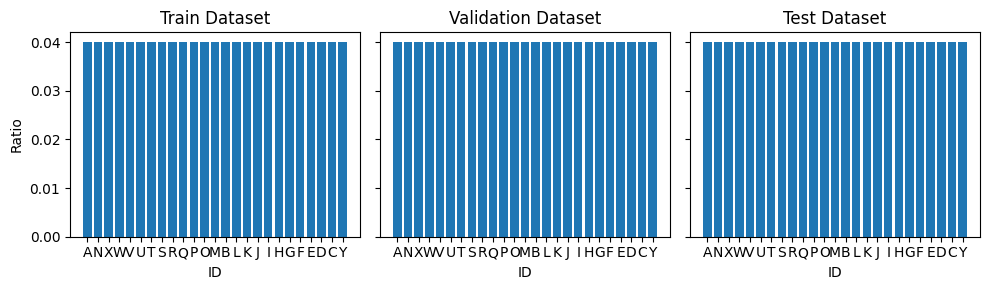

In [23]:
# 각 데이터셋에서 발전소 ID의 비율 계산
train_ratios = train_data['ID'].value_counts(normalize=True)
val_ratios = validation_data['ID'].value_counts(normalize=True)
test_ratios = test_data['ID'].value_counts(normalize=True)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

# Train 데이터셋의 발전소 분포 비율
axes[0].bar(train_ratios.index, train_ratios.values)
axes[0].set_title('Train Dataset')
axes[0].set_xlabel('ID')
axes[0].set_ylabel('Ratio')

# Validation 데이터셋의 발전소 분포 비율
axes[1].bar(val_ratios.index, val_ratios.values)
axes[1].set_title('Validation Dataset')
axes[1].set_xlabel('ID')

# Test 데이터셋의 발전소 분포 비율
axes[2].bar(test_ratios.index, test_ratios.values)
axes[2].set_title('Test Dataset')
axes[2].set_xlabel('ID')

plt.tight_layout()
plt.show()

- 모든 데이터셋에서 비율이 동일함
 
### 3.2.3 데이터 스케일링

**1. 데이터 범위 확인**

💥 **MISSION**

> train_data의 요약 통계 정보를 확인해보기

In [24]:
train_data.describe()

,CAPACITY,GHI,DNI,DHI,TEMP,CLOUDS,DEWPT,PRES,RH,SLP,...,VIS,HUMIDITY,GEN,Day sin,Day cos,Year sin,Year cos,Wx,Wy,RAIN_SNOW
count,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000,...,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000,64375.000
mean,1182.400,201.086,321.620,38.484,11.465,43.379,6.174,983.988,68.611,1018.840,...,15.168,71.939,143.304,-0.001,0.002,-0.824,0.252,0.564,-0.262,0.155
std,908.102,277.601,377.353,45.608,9.294,39.775,8.875,32.236,19.371,6.608,...,2.928,21.413,316.244,0.707,0.708,0.186,0.471,1.934,2.079,1.213
min,56.000,0.000,0.000,0.000,-18.400,0.000,-26.500,859.700,14.000,961.500,...,0.000,0.000,0.000,-1.000,-1.000,-1.000,-0.588,-13.633,-16.105,0.000
25%,701.000,0.000,0.000,0.000,7.300,0.000,1.200,950.000,54.000,1015.000,...,16.000,57.000,0.000,-0.707,-0.707,-0.973,-0.167,-0.504,-1.408,0.000
50%,947.000,0.000,0.000,0.000,12.800,42.000,6.700,998.500,70.000,1019.000,...,16.000,75.000,0.000,0.000,0.000,-0.895,0.290,0.278,-0.000,0.000
75%,1028.000,421.710,763.870,88.980,17.800,85.000,12.500,1008.000,85.000,1024.000,...,16.000,91.000,148.800,0.707,0.707,-0.728,0.686,1.236,1.032,0.000
max,4050.000,947.350,927.160,121.930,38.900,100.000,27.000,1030.900,100.000,1034.000,...,16.000,100.000,2894.400,1.000,1.000,-0.336,0.942,20.600,18.764,77.000


🔬 **데이터 범위 확인 결과 해석**

- 모든 데이터의 스케일이 다름 ☞ 모두 스케일링 수행

**2. 스케일링 수행(훈련 데이터)**

💥 **MISSION**

> train_data에 알맞은 스케일링 수행해보기

In [25]:
# 회귀 분석이기에 MinMaxScaler 사용
from sklearn.preprocessing import MinMaxScaler

scale_columns = ['CAPACITY', 'GHI', 'DNI', 'DHI', 
                'TEMP', 'CLOUDS', 'DEWPT', 'PRES',
                'RH', 'SLP', 'UV', 'VIS', 'HUMIDITY',
                'Day sin', 'Day cos', 'Year sin', 'Year cos',
                'Wx', 'Wy', 'RAIN_SNOW']

StdScaler = MinMaxScaler()
# Train 데이터의 fitting과 스케일링
StdScaler.fit(train_data[scale_columns])
scaled_data = StdScaler.transform(train_data[scale_columns])

# 데이터프레임 변환
scaled_df = pd.DataFrame(scaled_data, columns=scale_columns)

scaled_train_data = pd.concat([train_data.drop(scale_columns, axis=1), scaled_df], axis=1)
scaled_train_data.head()

,DATE_TIME,ID,GEN,CAPACITY,GHI,DNI,DHI,TEMP,CLOUDS,DEWPT,...,UV,VIS,HUMIDITY,Day sin,Day cos,Year sin,Year cos,Wx,Wy,RAIN_SNOW
0,2022-08-26 00:00:00,A,0.000,0.155,0.000,0.000,0.000,0.682,1.000,0.843,...,0.000,0.938,0.920,0.500,1.000,0.288,0.000,0.408,0.415,0.001
1,2022-08-26 01:00:00,A,0.000,0.155,0.000,0.000,0.000,0.675,1.000,0.843,...,0.000,1.000,0.870,0.629,0.983,0.287,0.000,0.413,0.416,0.000
2,2022-08-26 02:00:00,A,0.000,0.155,0.000,0.000,0.000,0.677,1.000,0.843,...,0.000,1.000,0.800,0.750,0.933,0.286,0.001,0.406,0.418,0.000
3,2022-08-26 03:00:00,A,0.000,0.155,0.000,0.000,0.000,0.663,1.000,0.834,...,0.000,1.000,0.720,0.854,0.854,0.286,0.001,0.401,0.412,0.000
4,2022-08-26 04:00:00,A,0.000,0.155,0.000,0.000,0.000,0.647,1.000,0.798,...,0.000,1.000,0.700,0.933,0.750,0.285,0.002,0.407,0.416,0.000


**3. 스케일링 적용(검증, 테스트 데이터)**

In [26]:
# 검증용 데이터 스케일링 적용
scaled_data = StdScaler.transform(validation_data[scale_columns])
scaled_df = pd.DataFrame(scaled_data, columns=scale_columns)
scaled_val_df = pd.concat([validation_data.drop(scale_columns, axis=1), scaled_df], axis=1)

scaled_val_df.head()

,DATE_TIME,ID,GEN,CAPACITY,GHI,DNI,DHI,TEMP,CLOUDS,DEWPT,...,UV,VIS,HUMIDITY,Day sin,Day cos,Year sin,Year cos,Wx,Wy,RAIN_SNOW
0,2022-12-12 00:00:00,A,0.000,0.155,0.000,0.000,0.000,0.257,0.000,0.413,...,0.000,1.000,0.770,0.500,1.000,1.001,1.000,0.426,0.445,0.000
1,2022-12-12 01:00:00,A,0.000,0.155,0.000,0.000,0.000,0.265,1.000,0.424,...,0.000,1.000,0.750,0.629,0.983,1.002,1.000,0.416,0.436,0.000
2,2022-12-12 02:00:00,A,0.000,0.155,0.000,0.000,0.000,0.293,0.970,0.439,...,0.000,1.000,0.740,0.750,0.933,1.003,1.000,0.414,0.448,0.000
3,2022-12-12 03:00:00,A,0.000,0.155,0.000,0.000,0.000,0.295,0.900,0.447,...,0.000,1.000,0.740,0.854,0.854,1.004,1.001,0.409,0.433,0.000
4,2022-12-12 04:00:00,A,0.000,0.155,0.000,0.000,0.000,0.295,0.700,0.449,...,0.000,1.000,0.750,0.933,0.750,1.005,1.001,0.408,0.437,0.000


In [27]:
# 테스트 데이터 스케일링 적용
scaled_data = StdScaler.transform(test_data[scale_columns])
scaled_df = pd.DataFrame(scaled_data, columns=scale_columns)
scaled_test_df = pd.concat([test_data.drop(scale_columns, axis=1), scaled_df], axis=1)

scaled_test_df.head()

,DATE_TIME,ID,GEN,CAPACITY,GHI,DNI,DHI,TEMP,CLOUDS,DEWPT,...,UV,VIS,HUMIDITY,Day sin,Day cos,Year sin,Year cos,Wx,Wy,RAIN_SNOW
0,2023-01-11 16:00:00,A,29.616,0.155,0.213,0.646,0.535,0.461,0.470,0.437,...,0.108,1.000,0.200,0.067,0.250,1.783,1.027,0.398,0.384,0.000
1,2023-01-11 17:00:00,A,0.576,0.155,0.043,0.288,0.258,0.342,0.490,0.445,...,0.092,1.000,0.210,0.017,0.371,1.785,1.027,0.404,0.407,0.000
2,2023-01-11 18:00:00,A,0.000,0.155,0.000,0.000,0.000,0.291,0.520,0.428,...,0.000,1.000,0.250,0.000,0.500,1.786,1.026,0.407,0.416,0.000
3,2023-01-11 19:00:00,A,0.000,0.155,0.000,0.000,0.000,0.272,0.540,0.421,...,0.000,1.000,0.350,0.017,0.629,1.787,1.026,0.405,0.422,0.000
4,2023-01-11 20:00:00,A,0.000,0.155,0.000,0.000,0.000,0.260,0.540,0.413,...,0.000,1.000,0.460,0.067,0.750,1.788,1.026,0.398,0.423,0.000


## 3.3 예측 모델 생성

### 3.3.1 선형 모델 생성 및 학습 (통계기반)

📍 **Linear Regressor**

In [28]:
feature_columns = ['CAPACITY', 'GHI', 'DNI',
                    'DHI', 'TEMP', 'CLOUDS', 'DEWPT', 'PRES', 'RH', 'SLP', 'UV', 'VIS',
                    'HUMIDITY', 'Day sin', 'Day cos', 'Year sin', 'Year cos', 'Wx', 'Wy',
                    'RAIN_SNOW']
target_columns = ['GEN']
X_train = scaled_train_data[feature_columns]
y_train = scaled_train_data[target_columns]

In [29]:
from sklearn.linear_model import LinearRegression

# LinearRegressor 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

print('train 정확도 :',lr.score(X_train, y_train))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
train 정확도 : 0.574724099279522


### 3.3.2 트리기반 모델 생성 및 학습

📍 **RandomForest Regressor**

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=1004)
rf.fit(X_train, y_train)

print('train 정확도 :', rf.score(X_train, y_train))

train 정확도 : 0.9925591950154677


## 3.4 분석모델 성능 평가

**데이터 병합 및 분할**

In [31]:
# 행 기준으로 병합 및 test 데이터 생성
total_test_data = pd.concat([scaled_val_df, scaled_test_df], axis=0)
total_test_data.reset_index(drop=True, inplace=True)
X_test = total_test_data[feature_columns]
y_test = total_test_data[target_columns]

### 3.4.1 성능평가

📍**MSE**

In [32]:
# linear regression 모델 성능 평가
print('Linear Regression 성능평가')
y_pred=lr.predict(X_test)
print('test 정확도 :', lr.score(X_test, y_test))

# rf 모델 성능 평가
print('RF 성능평가')
y_pred=rf.predict(X_test)
print('test 정확도 :', rf.score(X_test, y_test))

Linear Regression 성능평가
test 정확도 : 0.4185674413846484
RF 성능평가
test 정확도 : 0.7708083251949461


### 3.4.2 결과 시각화

In [33]:
df_index = total_test_data[['ID','DATE_TIME', 'GEN']]
df_index

,ID,DATE_TIME,GEN
0,A,2022-12-12 00:00:00,0.000
1,A,2022-12-12 01:00:00,0.000
2,A,2022-12-12 02:00:00,0.000
3,A,2022-12-12 03:00:00,0.000
4,A,2022-12-12 04:00:00,0.000
...,...,...,...
27595,Y,2023-01-26 19:00:00,0.000
27596,Y,2023-01-26 20:00:00,0.000
27597,Y,2023-01-26 21:00:00,0.000
27598,Y,2023-01-26 22:00:00,0.000


In [34]:
df_predict = pd.DataFrame({"PREDICT":y_pred})
df_predict

,PREDICT
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
...,...
27595,0.000
27596,0.000
27597,0.000
27598,0.000


In [35]:
df_result = pd.concat([df_index, df_predict], axis=1)
df_result

,ID,DATE_TIME,GEN,PREDICT
0,A,2022-12-12 00:00:00,0.000,0.000
1,A,2022-12-12 01:00:00,0.000,0.000
2,A,2022-12-12 02:00:00,0.000,0.000
3,A,2022-12-12 03:00:00,0.000,0.000
4,A,2022-12-12 04:00:00,0.000,0.000
...,...,...,...,...
27595,Y,2023-01-26 19:00:00,0.000,0.000
27596,Y,2023-01-26 20:00:00,0.000,0.000
27597,Y,2023-01-26 21:00:00,0.000,0.000
27598,Y,2023-01-26 22:00:00,0.000,0.000


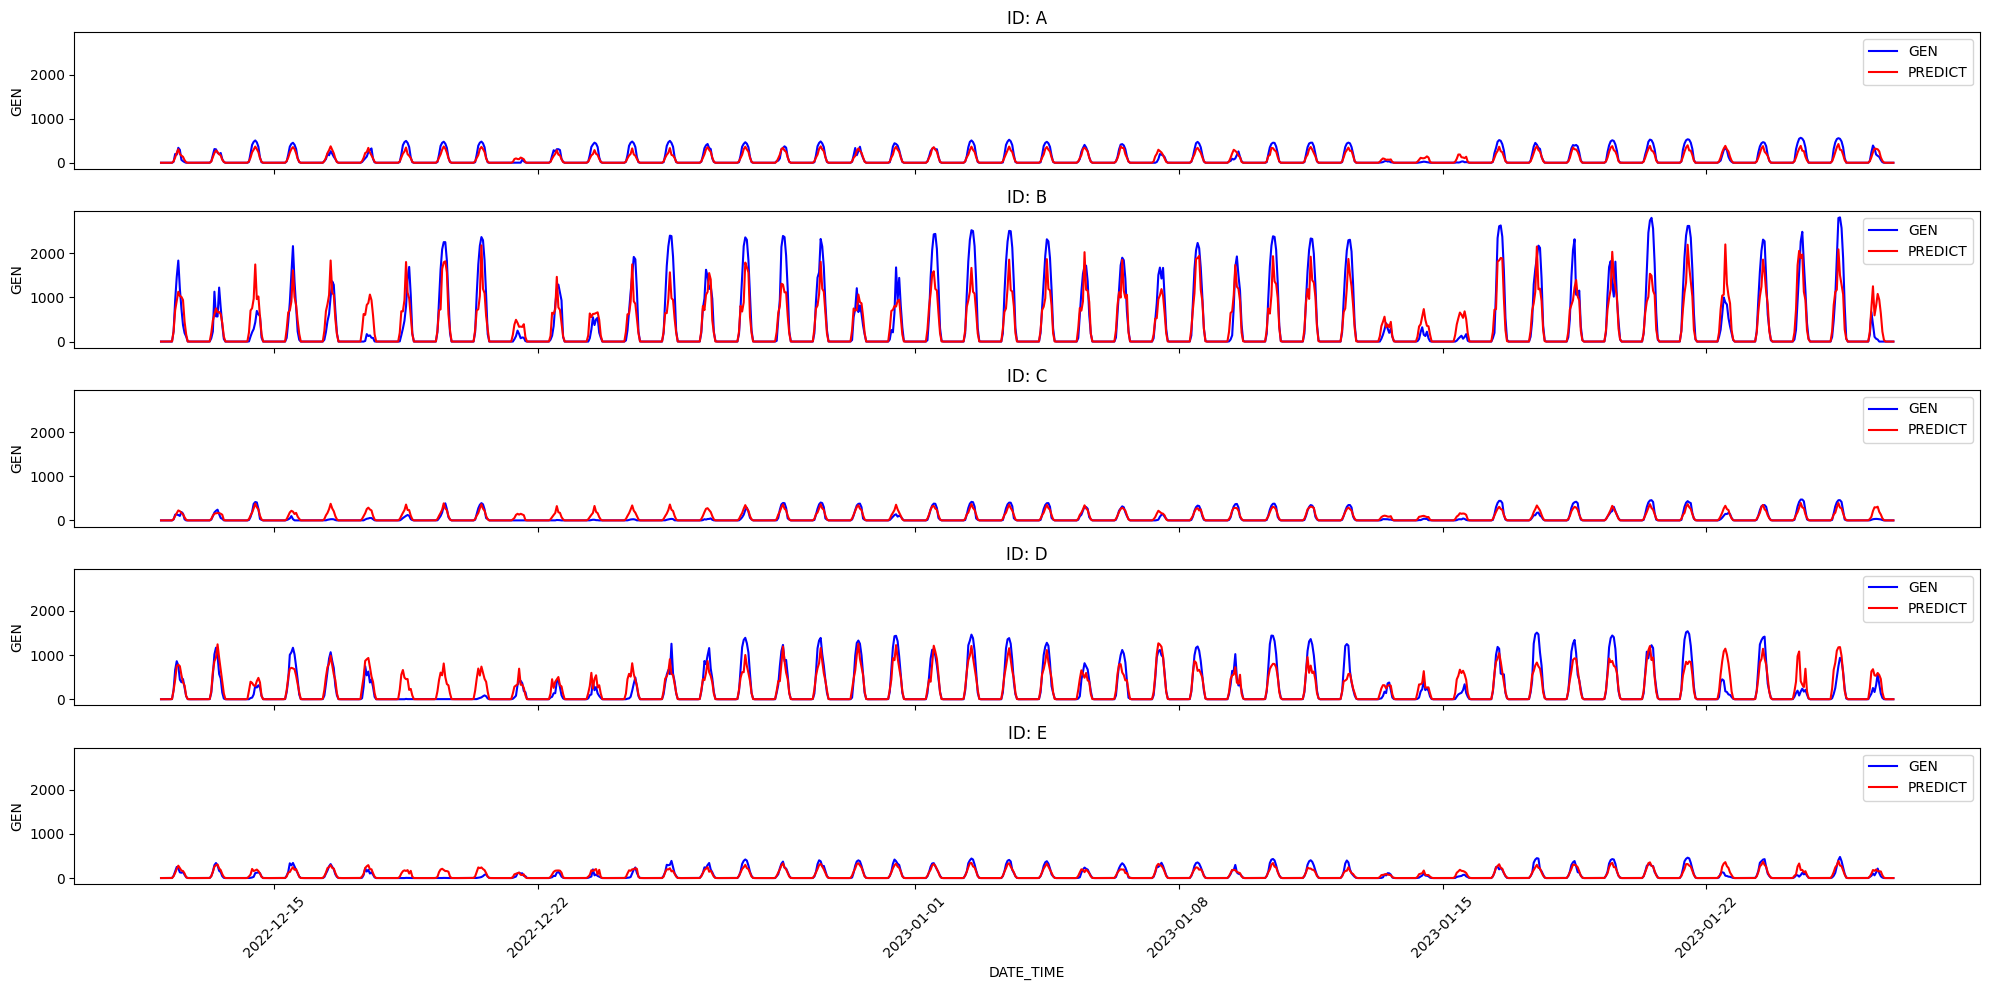

In [36]:
import matplotlib.pyplot as plt

# 고유 ID 목록 생성 (상위 5개만 선택)
unique_ids = df_result['ID'].unique()[:5]

# 5x1 그리드 생성
fig, axes = plt.subplots(5, 1, figsize=(20, 10), sharex=True, sharey=True)

# 각 ID별로 그래프 그리기
for i, ax in enumerate(axes.flatten()):
    id = unique_ids[i]
    # 현재 ID에 해당하는 데이터 필터링
    df_filtered = df_result[df_result['ID'] == id]
    
    # DATE_TIME에 따른 GEN과 PREDICT 그래프 그리기
    sns.lineplot(data=df_filtered, x='DATE_TIME', y='GEN', ax=ax, label='GEN', color='blue')
    sns.lineplot(data=df_filtered, x='DATE_TIME', y='PREDICT', ax=ax, label='PREDICT', color='red')
    
    # 제목 설정
    ax.set_title(f'ID: {id}')
    ax.tick_params(axis='x', rotation=45)  # x축 라벨 회전

# 전체 그래프에 대한 레이아웃 조정
plt.tight_layout()
plt.show()

## 3.5 모델 성능 개선

모델의 성능을 개선시키기 위한 방법에는 여러가지가 있습니다. 모델 자체를 변경하여 수행해 볼 수 있고, 모델에 사용된 변수들을 변경해가며 수행해볼수도 있습니다. 그리고 마지막에는 모델의 하이퍼파라미터를 조정(튜닝)하면서 더 나은 결과를 이끌어 낼 수 있습니다. 이번 실습에서는 이를 하나씩 수행해보며 어떤 차이점이 있는지 알아봅니다.

### 3.5.1 모델 변경

성능이 좋은 트리기반 모델 중 하나인 Xgboost를 사용해봅니다.

📍**XGBoost**

In [37]:
from xgboost import XGBRegressor

# 모델 생성 및 훈련
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb.fit(X_train, y_train)
print('train 정확도 :', xgb.score(X_train, y_train))

train 정확도 : 0.9774095519161353


In [38]:
print('test 정확도 :', xgb.score(X_test, y_test))

test 정확도 : 0.7487624228024197


### 3.5.2 Feature selection

사용된 다양한 변수들 중 크게 연관성이 없는 변수거나, 상관관계가 높은 즉, 차이가 없는 변수들은 제거하여 모델의 해석력을 높입니다.

📍 **Feature importance**

트리 기반의 모델은 입력된 모든 변수를 사용하여 룰이되는 트리를 만들게 됩니다. 이때, 어떤 변수가 주요하게 예측에 사용되었는지를 나타내는 feature importance를 통해 중요도가 낮은 변수를 제거할 수 있습니다.

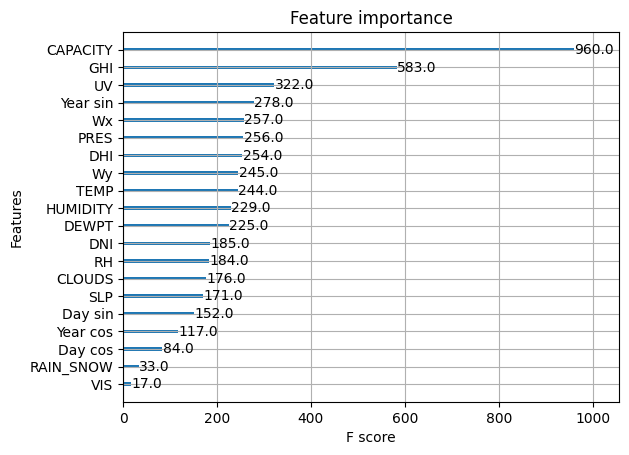

In [39]:
from xgboost import plot_importance

# 피처 중요도 시각화
plot_importance(xgb)
plt.show()

📍 **상관계수 행렬**

사용된 설명변수 간 상관계수가 높은 변수들은 유사한 정보를 포함하고 있을 가능성이 큽니다. 이런 변수들이 존재할 경우, 트리 모형은 이러한 변수들 중 일부만 선택하여 사용할 가능성이 높습니다. 이로 인해, 상관된 변수들이 많을 경우 정보 중복이 발생할 수 있지만, 이는 직접적인 문제를 일으키기보다는 변수 중요도 계산 시 중복된 정보로 인해 과대 평가될 수 있습니다.

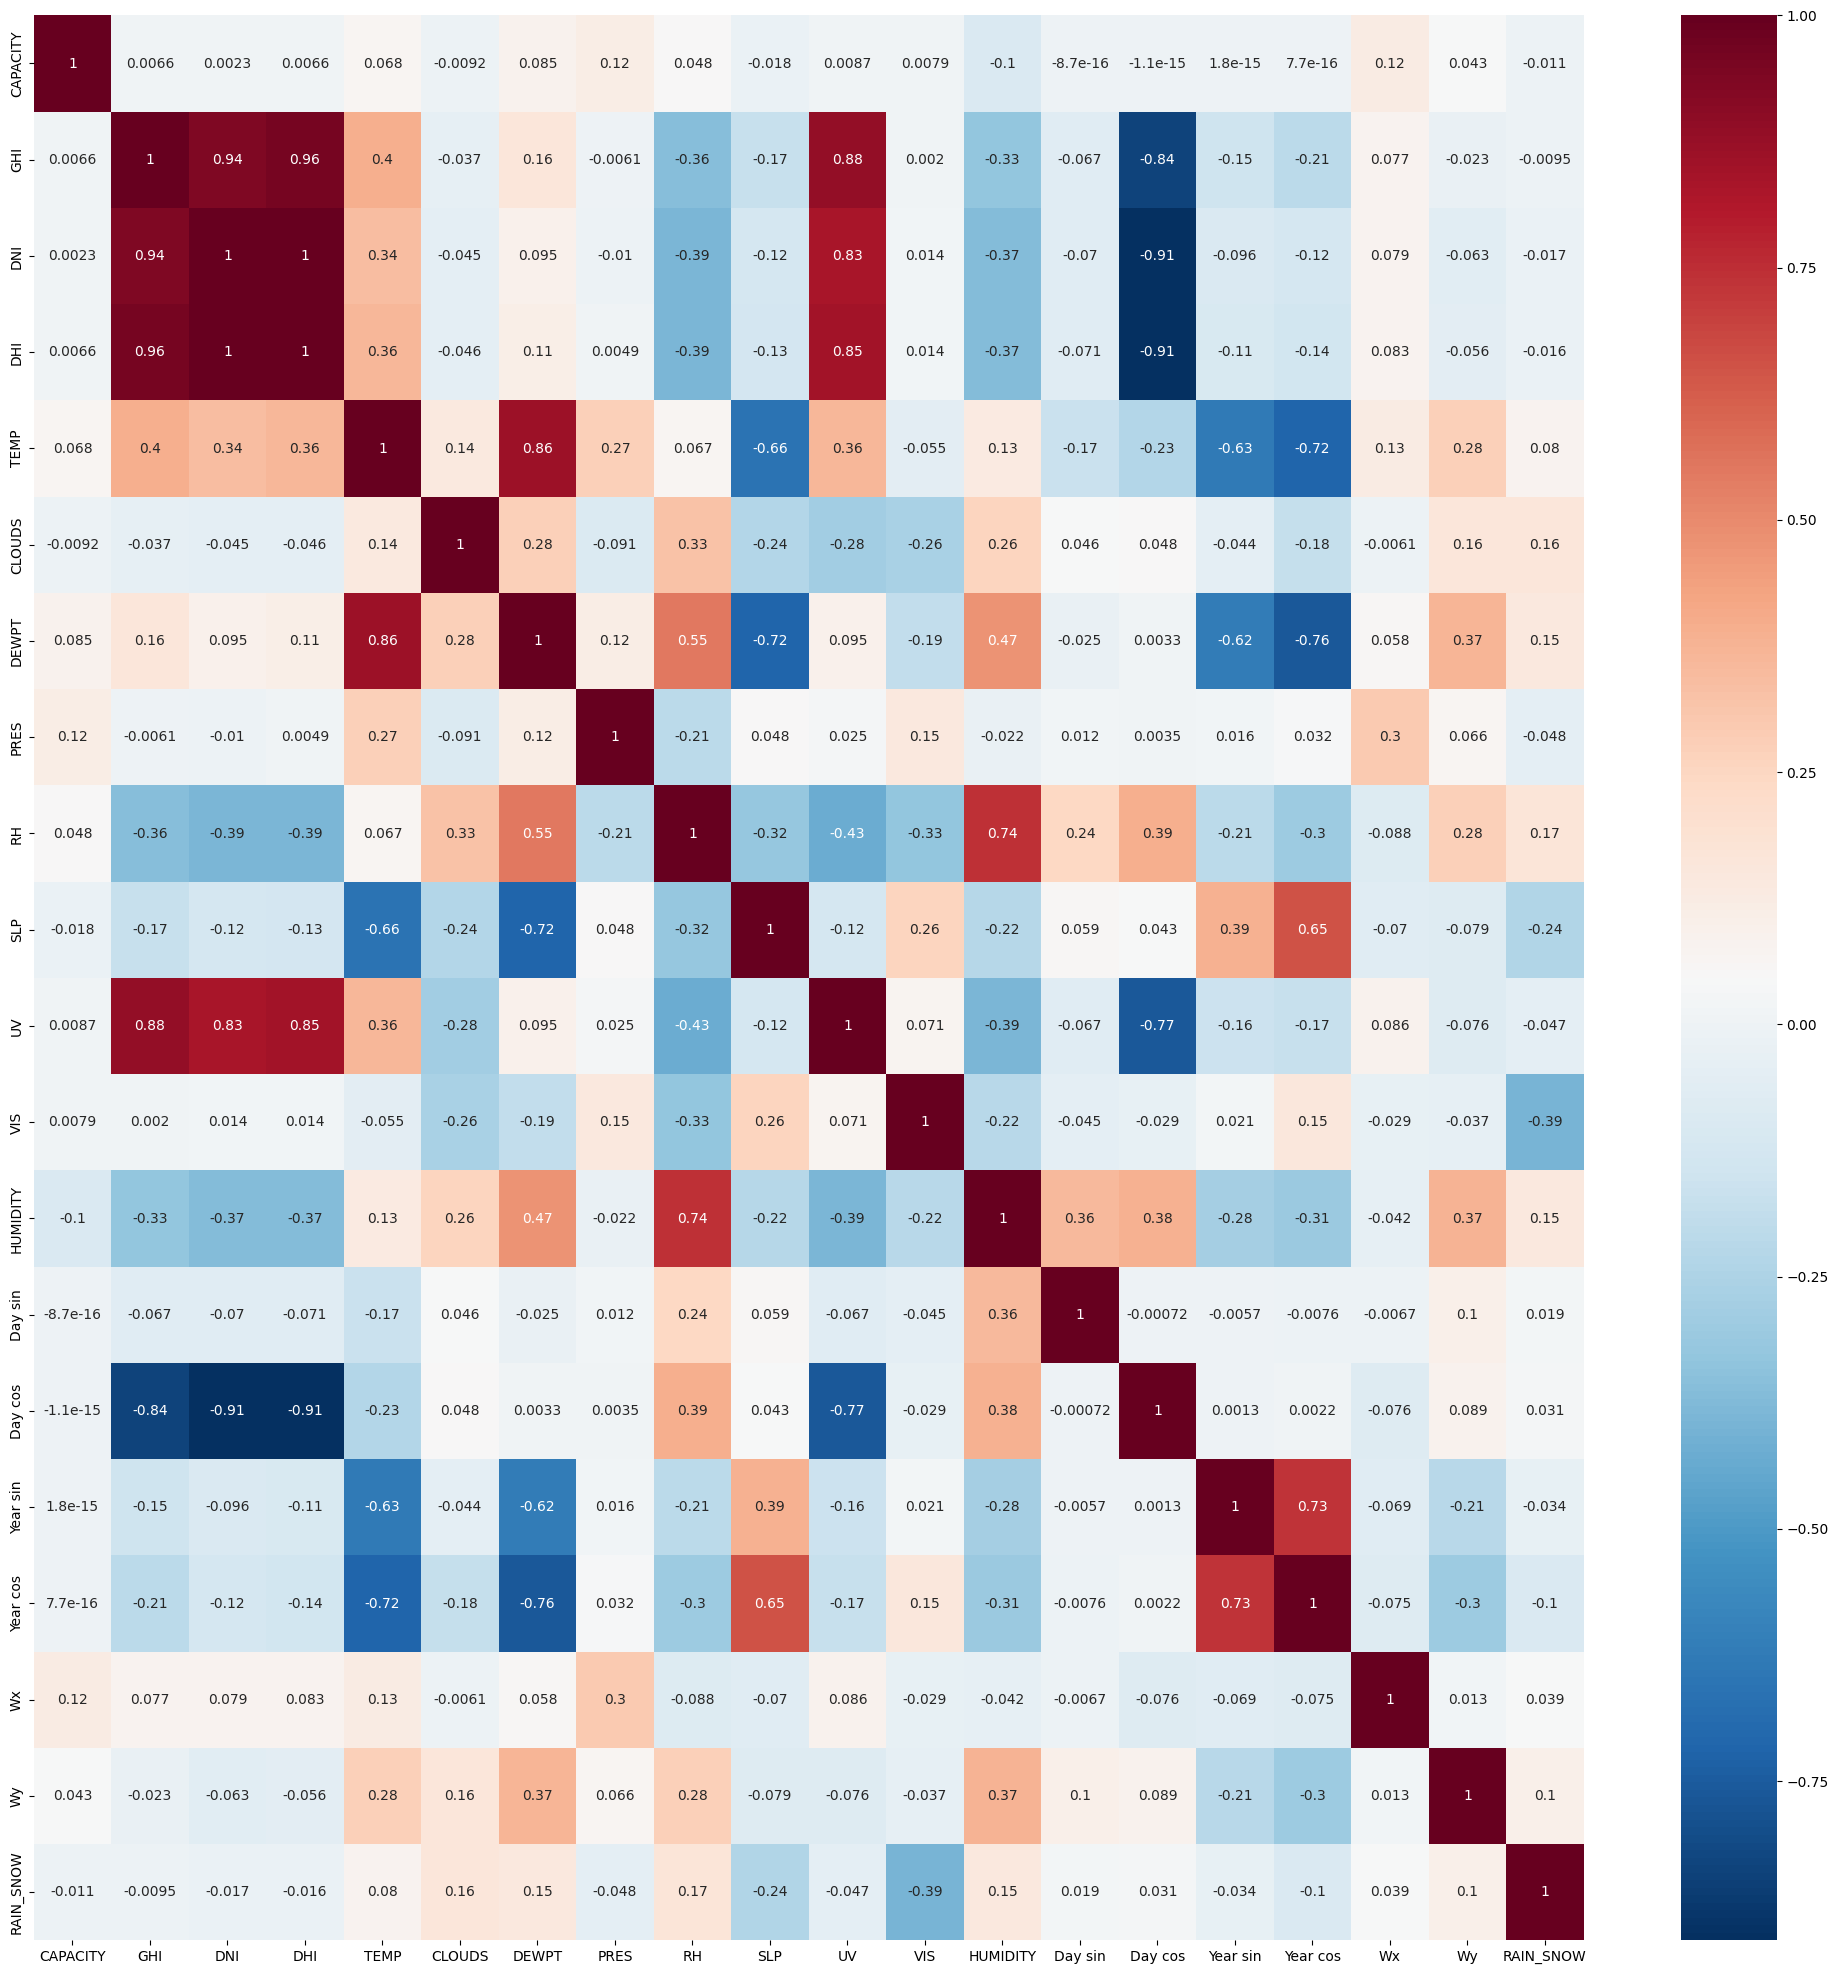

In [40]:
solar_corr = X_train.corr(method='pearson')
plt.figure(figsize=(25, 25))
sns.heatmap (solar_corr, xticklabels = solar_corr.columns, 
             yticklabels = solar_corr.columns, cmap = 'RdBu_r', annot = True)
plt.show()

💥 **MISSION**
- Feature importance와 상관계수를 고려하여 설명변수 집합을 새로 구성해보기

In [41]:
new_feature = [
    "CAPACITY",
    "DHI",
    "Day cos",
    "UV",
    "HUMIDITY",
    "RH",
    "CLOUDS",
    "Day sin",
    "PRES",
    "Year sin",
    "Year cos",
    "SLP",
    "Wy",
    "Wx",
    "DEWPT"
]

In [42]:
X_train_new = scaled_train_data[new_feature]

new_xgb = XGBRegressor(random_state=1004)
new_xgb.fit(X_train_new, y_train)

print('train 정확도 :', new_xgb.score(X_train_new, y_train))

train 정확도 : 0.9779027533722804


In [43]:
X_test_new = total_test_data[new_feature]

print('test 정확도 :', new_xgb.score(X_test_new, y_test))

test 정확도 : 0.7731196418815911


### 3.5.3 하이퍼 파라미터 조정

모델을 만들때 사용되는 파라미터를 하이퍼파라미터라고 합니다. 아무것도 넣지 않으면 모두 defualt 값으로 설정되나, 데이터 과학자는 이를 미세조정하며 최적의 결과로 이끌어 냅니다.

[Xgboost Hyperparameter](https://xgboost.readthedocs.io/en/stable/parameter.html)

📍 **OPTUNA**

In [44]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    if trial.number == 0:
        params = {}
    else:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
            'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
            'max_features': trial.suggest_categorical('max_features', [1.0, 'sqrt', 'log2']),
            'random_state': 1004
        }

    reg = RandomForestRegressor(**params)
    y_train_1d = np.array(y_train).ravel()
    return cross_val_score(reg, X_train, y_train_1d, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-06-20 16:19:16,048] A new study created in memory with name: no-name-97f3f251-4348-42a4-9e32-ee545b61f425
[I 2024-06-20 16:19:43,615] Trial 0 finished with value: -20331.521569265653 and parameters: {}. Best is trial 0 with value: -20331.521569265653.
[I 2024-06-20 16:20:54,743] Trial 1 finished with value: -20997.44893009703 and parameters: {'n_estimators': 415, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 17, 'max_features': 1.0}. Best is trial 0 with value: -20331.521569265653.
[I 2024-06-20 16:21:17,918] Trial 2 finished with value: -24012.885727379147 and parameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_split': 32, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: -20331.521569265653.


Number of finished trials: 3
Best trial: {}


In [45]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def objective(trial):
    if trial.number == 0:
        params = {}
    else:
        params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),
        'random_state': 1004
        }

    
    reg = xgb.XGBRegressor(**params)
    y_train_1d = np.array(y_train).ravel()
    return cross_val_score(reg, X_train_new, y_train_1d, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-06-20 16:21:17,933] A new study created in memory with name: no-name-e4e9e7d4-87ad-48e1-b52e-a363e4e811ea
[I 2024-06-20 16:21:22,713] Trial 0 finished with value: -19694.70516149997 and parameters: {}. Best is trial 0 with value: -19694.70516149997.
[I 2024-06-20 16:21:36,797] Trial 1 finished with value: -119566.42778133629 and parameters: {'n_estimators': 919, 'max_depth': 3, 'learning_rate': 6.115141350537867e-06, 'subsample': 0.6586851890262675, 'colsample_bytree': 0.5756317415241119, 'min_child_weight': 251, 'reg_lambda': 3.348938165321684e-07, 'reg_alpha': 6.094542846487083e-06}. Best is trial 0 with value: -19694.70516149997.
[I 2024-06-20 16:22:40,238] Trial 2 finished with value: -18688.884701060222 and parameters: {'n_estimators': 501, 'max_depth': 23, 'learning_rate': 0.027024375903933355, 'subsample': 0.9658552656634697, 'colsample_bytree': 0.7430933784392036, 'min_child_weight': 72, 'reg_lambda': 18.298480059167712, 'reg_alpha': 1.9262649650289825e-06}. Best is tri

Number of finished trials: 3
Best trial: {'n_estimators': 501, 'max_depth': 23, 'learning_rate': 0.027024375903933355, 'subsample': 0.9658552656634697, 'colsample_bytree': 0.7430933784392036, 'min_child_weight': 72, 'reg_lambda': 18.298480059167712, 'reg_alpha': 1.9262649650289825e-06}


In [46]:
# 좋은 성능의 모델로 개선
# best_trial = {'n_estimators': 135, 'max_depth': 27, 'learning_rate': 0.12112363453156222, 'subsample': 0.9322296675334183, 'colsample_bytree': 0.680519560433964, 'min_child_weight': 188, 'reg_lambda': 0.00010061834970536553, 'reg_alpha': 0.011545538724997063}
xgb_best = xgb.XGBRegressor(**study.best_trial.params)
xgb_best.fit(X_train_new, y_train)
print('train 정확도 :', xgb_best.score(X_train_new, y_train))

xgb_best.score(X_test_new, y_test)
print('test 정확도 :', xgb_best.score(X_test_new, y_test))

train 정확도 : 0.9770655313771058
test 정확도 : 0.7980376117867019


🔬 **성능 개선 결과 해석**

- 기존 Random Forest: 0.7708083251949461
- 성능개선 수행: 0.7903444412382243